In [1]:
import os

base_dir = r"C:\Users\omi_i\Downloads\archive\PetImages"
cats_dir = os.path.join(base_dir, "Cat")
dogs_dir = os.path.join(base_dir, "Dog")

print("Number of cat images:", len(os.listdir(cats_dir)))
print("Number of dog images:", len(os.listdir(dogs_dir)))


Number of cat images: 12499
Number of dog images: 12499


In [12]:
import tensorflow as tf

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 24824 files belonging to 2 classes.
Using 17377 files for training.
Found 24824 files belonging to 2 classes.
Using 4964 files for validation.
Classes: ['Cat', 'Dog']


In [3]:
from PIL import Image

def clean_folder(folder):
    removed = 0
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        try:
            img = Image.open(fpath)
            img.verify()
        except:
            os.remove(fpath)
            removed += 1
    print(f"Removed {removed} corrupted images from {folder}")

clean_folder(cats_dir)
clean_folder(dogs_dir)


Removed 0 corrupted images from C:\Users\omi_i\Downloads\archive\PetImages\Cat


C:\Users\omi_i\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Removed 0 corrupted images from C:\Users\omi_i\Downloads\archive\PetImages\Dog


In [32]:
def strict_clean_folder(folder):
    removed = 0
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        try:
            raw = tf.io.read_file(fpath)
            img = tf.image.decode_jpeg(raw, channels=3)  # force 3 channels
        except:
            print("Removing corrupted:", fpath)
            os.remove(fpath)
            removed += 1
    print(f"Removed {removed} corrupted images from {folder}")

cats_dir = r"C:\Users\omi_i\Downloads\archive\PetImages\Cat"
dogs_dir = r"C:\Users\omi_i\Downloads\archive\PetImages\Dog"

strict_clean_folder(cats_dir)
strict_clean_folder(dogs_dir)

Removed 0 corrupted images from C:\Users\omi_i\Downloads\archive\PetImages\Cat
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Dog\2050.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Dog\9942.jpg
Removed 2 corrupted images from C:\Users\omi_i\Downloads\archive\PetImages\Dog


In [13]:
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255) #--> normalizing(1-255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [14]:
#CNN Model

model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7
)

Epoch 1/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 281s 451ms/step - accuracy: 0.5798 - loss: 0.6722 - val_accuracy: 0.6972 - val_loss: 0.5811
Epoch 2/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 228s 419ms/step - accuracy: 0.7410 - loss: 0.5302 - val_accuracy: 0.7732 - val_loss: 0.4807
Epoch 3/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 214s 394ms/step - accuracy: 0.7897 - loss: 0.4469 - val_accuracy: 0.8060 - val_loss: 0.4210
Epoch 4/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 224s 411ms/step - accuracy: 0.8376 - loss: 0.3666 - val_accuracy: 0.8276 - val_loss: 0.3806
Epoch 5/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 218s 400ms/step - accuracy: 0.8670 - loss: 0.3094 - val_accuracy: 0.8322 - val_loss: 0.3929
Epoch 6/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 131s 240ms/step - accuracy: 0.8944 - loss: 0.2481 - val_accuracy: 0.8282 - val_loss: 0.4442
Epoch 7/7
544/544 ━━━━━━━━━━━━━━━━━━━━ 144s 264ms/step - accuracy: 0.9245 - loss: 0.1926 - val_accuracy: 0.8525 - val_loss: 0.3766


In [16]:
model.save("cats_dogs_cnn.h5")


In [17]:
loss, acc = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8627 - loss: 0.3628
Final Validation Accuracy: 85.25%


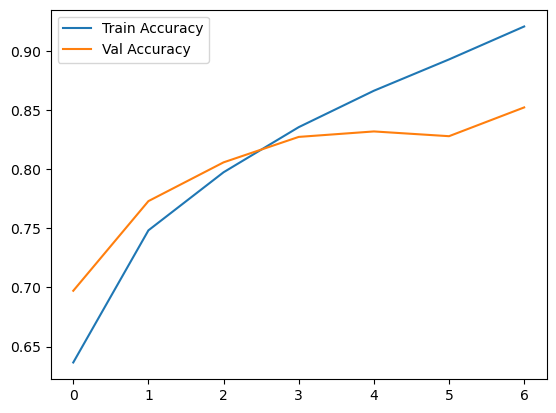

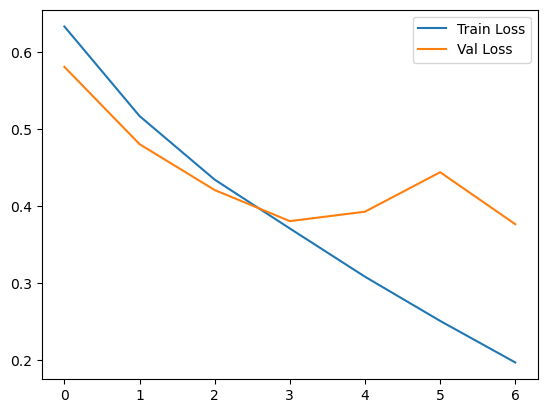

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [19]:
from tensorflow.keras.models import load_model
import numpy as np
import cv2

# Load trained CNN
model = load_model("cats_dogs_cnn.h5")

In [27]:
img_path = r"C:\Users\omi_i\Downloads\dog.jpg"

# Load and preprocess
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))   # resize same as training
img = img / 255.0                   # normalize
img = np.expand_dims(img, axis=0)   # make batch of 1


In [29]:
from tensorflow.keras.models import load_model
model = load_model("cats_dogs_cnn.h5")
class_names = ["Cat", "Dog"]

def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    predicted_class = int(prediction > 0.5)
    label = class_names[predicted_class]

    print(f"Prediction: {label} (confidence: {prediction:.2f})")
predict_image(r"C:\Users\omi_i\Downloads\dog.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Prediction: Dog (confidence: 1.00)


In [28]:
prediction = model.predict(img)[0][0]  # single value
label = "Cat" if prediction > 0.5 else "Dog"

print(f"Prediction: {label} (confidence: {prediction:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: Cat (confidence: 1.00)


In [50]:
img_path = r"C:\Users\omi_i\Downloads\dd.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Optional: OpenCV loads as BGR
img = cv2.resize(img, (128, 128))
img = img / 255.0
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)[0][0]
label = "Dog" if prediction > 0.5 else "Cat"
print(f"Prediction: {label} (confidence: {prediction:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediction: Cat (confidence: 0.00)


In [33]:
base_dir = r"C:\Users\omi_i\Downloads\archive\PetImages"
cats_dir = os.path.join(base_dir, "Cat")
dogs_dir = os.path.join(base_dir, "Dog")

print("Number of cat images:", len(os.listdir(cats_dir)))
print("Number of dog images:", len(os.listdir(dogs_dir)))

def strict_clean_folder(folder):
    removed = 0
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)
        try:
            # OpenCV check
            img = cv2.imread(fpath)
            if img is None:
                raise ValueError("Cannot read image")
            # TensorFlow decode check
            raw = tf.io.read_file(fpath)
            tf.image.decode_jpeg(raw, channels=3)
        except:
            print("Removing corrupted:", fpath)
            os.remove(fpath)
            removed += 1
    print(f"Removed {removed} corrupted images from {folder}")

strict_clean_folder(cats_dir)
strict_clean_folder(dogs_dir)

img_size = (128, 128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)  # ['Cat','Dog']


normalization_layer = layers.Rescaling(1./255)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15  #  increase to 20-25 for better accuracy
)

model.save("cats_dogs_cnn.h5")

loss, acc = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {acc*100:.2f}%")

def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    print(f"Prediction: {label} (confidence: {confidence:.2f})")


predict_image(r"C:\Users\omi_i\Downloads\dog.jpg")


Number of cat images: 12427
Number of dog images: 12395
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\10125.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\10501.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\10820.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\11210.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\11565.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\11874.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\11935.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\140.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\2663.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\3300.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\3491.jpg
Removing corrupted: C:\Users\omi_i\Downloads\archive\PetImages\Cat\4833.jpg
Removing corrupted: C:\Use

C:\Users\omi_i\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,665 (12.61 MB)

 Trainable params: 3,305,217 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 369s 524ms/step - accuracy: 0.6081 - loss: 1.2049 - val_accuracy: 0.6237 - val_loss: 0.6270
Epoch 2/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 393s 631ms/step - accuracy: 0.6908 - loss: 0.5865 - val_accuracy: 0.7582 - val_loss: 0.4934
Epoch 3/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 349s 561ms/step - accuracy: 0.7344 - loss: 0.5388 - val_accuracy: 0.7673 - val_loss: 0.4813
Epoch 4/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 330s 531ms/step - accuracy: 0.7624 - loss: 0.4960 - val_accuracy: 0.7685 - val_loss: 0.5081
Epoch 5/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 325s 524ms/step - accuracy: 0.7878 - loss: 0.4582 - val_accuracy: 0.6562 - val_loss: 0.7941
Epoch 6/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 329s 531ms/step - accuracy: 0.8207 - loss: 0.4174 - val_accuracy: 0.7620 - val_loss: 0.4925
Epoch 7/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 321s 517ms/step - accuracy: 0.8277 - loss: 0.3872 - val_accuracy: 0.8147 - val_loss: 0.4110
Epoch 8/15
620/620 ━━━━━━━━━━━━━━━━━━━━ 321s 517ms/step - accuracy: 0.8362 -

155/155 ━━━━━━━━━━━━━━━━━━━━ 28s 178ms/step - accuracy: 0.8495 - loss: 0.3314
Final Validation Accuracy: 84.68%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
Prediction: Dog (confidence: 0.99)


In [37]:
from tensorflow.keras.models import load_model
model = load_model("cats_dogs_cnn.h5")

In [42]:
def predict_image(img_path, class_names):
    img = cv2.imread(img_path)
    if img is None:
        print("Image not found or cannot be read:", img_path)
        return

    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0][0]

    if prediction > 0.5:
        label = class_names[1]
        confidence = prediction
    else:
        label = class_names[0]
        confidence = 1 - prediction

    print(f"Prediction: {label} (confidence: {confidence:.2f})")

# Usage
predict_image(r"C:\Users\omi_i\Downloads\download.jpg", class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Prediction: Dog (confidence: 1.00)


In [59]:
def extract_graph_features(img_path, patch_size=16):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None or img.size == 0:
            return None

        img = cv2.resize(img, (128, 128))

        # divide into patches
        patches = []
        for i in range(0, img.shape[0], patch_size):
            for j in range(0, img.shape[1], patch_size):
                patch = img[i:i+patch_size, j:j+patch_size]
                if patch.size == 0:
                    continue
                patches.append(patch.flatten())  # keep pixel values

        patches = np.array(patches)  # shape = (#patches, pixels_per_patch)

        if patches.shape[0] < 2:
            return None

        # ✅ correlation between patches
        corr_matrix = np.corrcoef(patches)
        if np.isnan(corr_matrix).any():
            return None

        # build graph
        G = nx.Graph()
        n = corr_matrix.shape[0]
        for i in range(n):
            for j in range(i+1, n):
                G.add_edge(i, j, weight=corr_matrix[i, j])

        if G.number_of_nodes() == 0:
            return None

        # graph features
        degree = np.mean([d for _, d in G.degree()])
        clustering = nx.average_clustering(G, weight='weight')
        efficiency = nx.global_efficiency(G)

        return [degree, clustering, efficiency]

    except Exception as e:
        print(f"Skipping {img_path} due to error: {e}")
        return None


In [64]:
import os
import cv2
import numpy as np
from tqdm import tqdm

cats_dir = r"C:\Users\omi_i\Downloads\archive\PetImages\Cat"
dogs_dir = r"C:\Users\omi_i\Downloads\archive\PetImages\Dog"

img_size = (64, 64)  # smaller than 128x128 → faster

def extract_features(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            return None

        # Resize
        img = cv2.resize(img, img_size)

        # Convert to grayscale for texture
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # --- 1. Basic intensity stats
        mean_val = np.mean(gray)
        std_val = np.std(gray)

        # --- 2. Edge density
        edges = cv2.Canny(gray, 100, 200)
        edge_density = np.mean(edges > 0)

        # --- 3. Histogram of pixel intensities (16 bins)
        hist_gray = cv2.calcHist([gray], [0], None, [16], [0, 256]).flatten()
        hist_gray = hist_gray / np.sum(hist_gray)  # normalize

        # --- 4. HOG features (low-dim version)
        hog = cv2.HOGDescriptor(
            _winSize=(64, 64),
            _blockSize=(16, 16),
            _blockStride=(8, 8),
            _cellSize=(8, 8),
            _nbins=9,
        )
        hog_features = hog.compute(gray)
        hog_features = hog_features.flatten()[:100]  # take first 100 for speed

        # --- Final feature vector
        return np.concatenate([[mean_val, std_val, edge_density], hist_gray, hog_features])
    except:
        return None

# --- Loop over dataset ---
features_list, labels_list = [], []

for file in tqdm(os.listdir(cats_dir)):
    f = extract_features(os.path.join(cats_dir, file))
    if f is not None:
        features_list.append(f)
        labels_list.append(0)

for file in tqdm(os.listdir(dogs_dir)):
    f = extract_features(os.path.join(dogs_dir, file))
    if f is not None:
        features_list.append(f)
        labels_list.append(1)

features = np.array(features_list)
labels = np.array(labels_list)

print("Final feature matrix shape:", features.shape)
print("Final labels shape:", labels.shape)


100%|██████████| 12366/12366 [04:02<00:00, 51.06it/s]

Final feature matrix shape: (24771, 119)
Final labels shape: (24771,)


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42
)

model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss"
)

model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print("Test Accuracy:", accuracy)
